# This notebook is based on the paper: "Global-Convergence-Nonconvex-Optimization". 

The aim of this project is to find the global solution to  
\begin{equation}
  \min_{x \in \mathbb{R}^n} f(x).
\end{equation}

To obtain a global minimizer, the main idea is to minimize the Moreau Envelop instead, which "convexifies" the original function. To make the Moreau envelope tractable, we use connections to Hamilton-Jacobi Equations via the Cole-Hopf and Hopf-Lax formulas to efficiently compute the gradients of the Moreau envelope.

In [240]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
import time
from IPython.display import clear_output


from test_functions import Griewank, AlpineN1, Drop_Wave, Levy, Rastrigin, Ackley, Sin, Sinc, MultiMinimaFunc
from test_functions import Griewank_numpy, AlpineN1_numpy, Drop_Wave_numpy, Levy_numpy, Rastrigin_numpy, Ackley_numpy, Sin_numpy, Sinc_numpy, MultiMinimaFunc_numpy

seed   = 30
torch.manual_seed(seed)

### Create Class for Hamilton-Jacobi Moreau Adaptive Descent (HJ_MAD)

The Moreau envelop of $f$ is given by
\begin{equation}
  u(x,t) \triangleq \inf_{z\in \mathbb{R}^n} f(z) + \dfrac{1}{2t}\|z-x\|^2.
\end{equation}

We leverage the fact that the solution to the Moreau envelope above satisfies the Hamilton-Jacobi Equation
\begin{equation}
  \begin{split}
    u_t^\delta  + \frac{1}{2}\|Du^\delta  \|^2 \ = \frac{\delta}{2} \Delta u^\delta \qquad &\text{ in }  \mathbb{R}^n\times (0,T]
    \\
    u = f \qquad &\text{ in } \mathbb{R}^n\times \{t = 0\}
  \end{split}
\end{equation}
when $\delta = 0$. 

By adding a viscous term ($\delta > 0$), we are able to approximate the solution to the HJ equation using the Cole-Hopf formula to obtain
\begin{equation}
  u^\delta(x,t) = - \delta \ln\Big(\Phi_t * \exp(-f/\delta)\Big)(x) = - \delta \ln \int_{\mathbb{R}^n} \Phi(x-y,t)  \exp\left(\frac{-f(y)}{\delta}\right) dy 
\end{equation}
where 
\begin{equation}
  \Phi(x,t) = \frac{1}{{(4\pi \delta t)}^{n/2}} \exp{\frac{-\|x\|^2}{4\delta t}}. 
\end{equation}
This allows us to write the Moreau Envelope (and its gradient) explicitly as an expectation. In this case, we compute the gradient as
\begin{equation}
  \nabla u^\delta(x,t) = \dfrac{1}{t}\cdot  \dfrac{\mathbb{E}_{y\sim  \mathbb{P}_{x,t}}\left[(x-y) \exp\left(-\delta^{-1}\tilde{f}(y)\right) \right]}
    {\mathbb{E}_{y\sim  \mathbb{P}_{x,t}}\left[ \exp\left(-\delta^{-1} \tilde{f}(y)\right) \right]}
\end{equation}


### Define classes for HJ-MAD, Pure Random Search, and Gradient Descent 

In [241]:
# ------------------------------------------------------------------------------------------------------------
# HJ Moreau Adaptive Descent
# ------------------------------------------------------------------------------------------------------------

class HJ_MAD:
    ''' 
        Hamilton-Jacobi Moreau Adaptive Descent (HJ_MAD) is used to solve nonconvex minimization
        problems via a zeroth-order sampling scheme.
        
        Inputs:
          1)  f            = function to be minimized. Inputs have size (n_samples x n_features). Outputs have size n_samples
          2)  x_true       = true global minimizer
          3)  delta        = coefficient of viscous term in the HJ equation
          4)  int_samples  = number of samples used to approximate expectation in heat equation solution
          5)  x_true       = true global minimizer
          6)  t_vec        = time vector containig [initial time, minimum time allowed, maximum time]
          7)  max_iters    = max number of iterations
          8)  tol          = stopping tolerance
          9)  theta        = parameter used to update tk
          10) beta         = exponential averaging term for gradient beta (beta multiplies history, 1-beta multiplies current grad)
          11) eta_vec      = vector containing [eta_minus, eta_plus], where eta_minus < 1 and eta_plus > 1 (part of time update)
          11) alpha        = step size. has to be in between (1-sqrt(eta_minus), 1+sqrt(eta_plus))
          12) fixed_time   = boolean for using adaptive time
          13) verbose      = boolean for printing
          14) accelerated  = boolean for using Accelerated Gradient Descent

        Outputs:
          1) x_opt                    = optimal x_value approximation
          2) xk_hist                  = update history
          3) tk_hist                  = time history
          4) fk_hist                  = function value history
          5) xk_error_hist            = error to true solution history 
          6) rel_grad_uk_norm_hist    = relative grad norm history of Moreau envelope
    '''
    def __init__(self, f, x_true, delta=0.1, int_samples=100, t_vec = [1.0, 1e-3, 1e1], max_iters=5e4, 
                 tol=5e-2, theta=0.9, beta=[0.9], eta_vec = [0.9, 1.1], alpha=1.0, fixed_time=False, 
                 verbose=True, accelerated=False):
      
      self.delta            = delta
      self.f                = f
      self.int_samples      = int_samples
      self.max_iters        = max_iters
      self.tol              = tol
      self.t_vec            = t_vec
      self.theta            = theta
      self.x_true           = x_true
      self.beta             = beta 
      self.alpha            = alpha 
      self.eta_vec          = eta_vec
      self.fixed_time       = fixed_time
      self.verbose          = verbose
      self.accelerated     = accelerated
      
      # check that alpha is in right interval
      assert(alpha >= 1-np.sqrt(eta_vec[0]))
      assert(alpha <= 1+np.sqrt(eta_vec[1]))
    
    def compute_grad_uk(self, x, t, f, delta, eps=1e-12):
      ''' 
          compute gradient of Moreau envelope
      '''

      standard_dev = np.sqrt(delta*t)

      n_features = x.shape[0]
      y = standard_dev * torch.randn(self.int_samples, n_features) + x
      
      exp_term = torch.exp(-f(y)/delta)
      v_delta       = torch.mean(exp_term)

      # separate grad_v into two terms for numerical stability
      numerator = y*exp_term.view(self.int_samples, 1)
      numerator = torch.mean(numerator, dim=0)
      grad_uk = (x -  numerator/(v_delta + eps)) # the t gets canceled with the update formula

      uk       = -delta * torch.log(v_delta+eps)

      return grad_uk, uk

    def update_time(self, tk, rel_grad_uk_norm):
      '''
        time step rule

        if ‖gk_plus‖≤ theta (‖gk‖+ eps):
          min (eta_plus t,T)
        else
          max (eta_minus t,t_min) otherwise

        OR:
        
        if rel grad norm too small, increase tk (with maximum T).
        else if rel grad norm is too "big", decrease tk with minimum (t_min)
      '''

      eta_minus = self.eta_vec[0]
      eta_plus = self.eta_vec[1]
      T = self.t_vec[2]
      t_min = self.t_vec[1]

      if rel_grad_uk_norm <= self.theta:
        # increase t when relative gradient norm is smaller than theta
        tk = min(eta_plus*tk , T)
      else:
        # decrease otherwise t when relative gradient norm is smaller than theta
        tk = max(eta_minus*tk, t_min)

      return tk
    
    def plot(self,k,x0, xk,tk,first_moment,error):
      # Compute the Moreau envelope and plot f(x)
      x_range = np.linspace(-30, 30, 1000)  # Adjust the range based on your problem

      # Use the numpy version of f to compute f_values
      f_values = np.array([f_numpy(x) for x in x_range])

      # Calculate Moreau envelope at xk
      x_hat = (xk - tk * first_moment).detach().cpu().numpy()

      
      # Compute the Moreau envelope for the current xk
      moreau_values = []
      for x in x_range:

          moreau_val = f_numpy(x_hat) + (1 / (2 * tk)) * ((x_hat - x) ** 2)
          moreau_values.append(moreau_val)

      # Convert moreau_values to a NumPy array
      moreau_values = np.array(moreau_values)

      # Ensure the length of moreau_values matches x_range
      if len(moreau_values) != len(x_range):
          raise ValueError("The lengths of moreau_values and x_range do not match.")

      # Plot f(x) and Moreau envelope
      plt.figure(figsize=(10, 6))
      plt.plot(x_range, f_values, label='f(x)', color='black')
      # Plot the points x_hat and xk
      plt.scatter(x_hat, f_numpy(x_hat), color='red', label=r'Local Minimizer, $\hat{x}=prox_{tf}(x_k)\approx x_k-t_k g_k$', s=100, zorder=4, marker='x')
      plt.plot(x_range, moreau_values, label=rf'Moreau Envelope, $u(x,t_k))$ where $t_k=${tk}', color='red')
      plt.scatter(xk, f_numpy(xk), color='blue', label=r'$f(x_k)$', s=100, zorder=4)
      plt.scatter(x0, f_numpy(x0), color='green', label=r'$f(x_0)$', s=100, zorder=4)
      plt.scatter(self.x_true, f_numpy(self.x_true), color='purple', label=r'Global Minima, $f(x_{true})$', s=100, zorder=5, marker='x')
      plt.title(f'f(x) and Moreau Envelope\nIteration {k+1}, Error={error:.3f}, Tol={self.tol}')
      plt.xlabel('x')
      plt.ylabel('Function Value')
      plt.ylim(-10, 120)
      plt.xlim(-30, 30)
      plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=1)
      # Add major grid lines
      plt.grid(which='major', linestyle='-', linewidth='0.5')

      # Add minor grid lines
      plt.minorticks_on()  # Enable minor ticks
      plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
      plt.grid(which='minor', linestyle=':', linewidth='0.5')
      
      # Save the plot as a PNG file
      plt.savefig(f'moreau_envelope_iteration.png', dpi=300, bbox_inches='tight')
      plt.close()  # Close the plot to free up memory
      time.sleep(1)

    def run(self, x0):

      n_features            = x0.shape[0]

      xk_hist               = torch.zeros(self.max_iters, n_features)
      xk_error_hist         = torch.zeros(self.max_iters)
      rel_grad_uk_norm_hist = torch.zeros(self.max_iters)
      fk_hist               = torch.zeros(self.max_iters)
      tk_hist               = torch.zeros(self.max_iters)
      counter               = 1

      xk    = x0
      x_opt = xk
      tk    = self.t_vec[0]
      t_max = self.t_vec[2]

      # For Accelerated GD when k=0, yk = xk
      first_moment, _       = self.compute_grad_uk(xk, tk, self.f, self.delta)
      rel_grad_uk_norm      = 1.0

      fmt = '[{:3d}]: fk = {:6.2e} | xk_err = {:6.2e} '
      fmt += ' | |grad_uk| = {:6.2e} | tk = {:6.2e}'

      print('-------------------------- RUNNING HJ-MAD ---------------------------')
      print('dimension = ', dim, 'n_samples = ', self.int_samples)

      for k in range(self.max_iters):

        xk_hist[k,:]    = xk

        rel_grad_uk_norm_hist[k]  = rel_grad_uk_norm

        xk_error_hist[k] = torch.norm(xk - self.x_true)
        tk_hist[k]       = tk

        fk_hist[k]       = f(xk.view(1, n_features))

        self.plot(k,x0,xk,tk,first_moment,xk_error_hist[k])

        if self.verbose:
          print(fmt.format(k+1, fk_hist[k], xk_error_hist[k], rel_grad_uk_norm_hist[k], tk))

        if xk_error_hist[k] < self.tol:
          tk_hist = tk_hist[0:k+1]
          xk_hist = xk_hist[0:k+1,:]
          xk_error_hist = xk_error_hist[0:k+1]
          rel_grad_uk_norm_hist = rel_grad_uk_norm_hist[0:k+1]
          fk_hist               = fk_hist[0:k+1]
          print('HJ-MAD converged with rel grad norm {:6.2e}'.format(rel_grad_uk_norm_hist[k]))
          print('iter = ', k, ', number of function evaluations = ', len(xk_error_hist)*int_samples)
          break
        elif k==self.max_iters-1:
          print('HJ-MAD failed to converge with rel grad norm {:6.2e}'.format(rel_grad_uk_norm_hist[k]))
          print('iter = ', k, ', number of function evaluations = ', len(xk_error_hist)*int_samples)
          print('Used fixed time = ', self.fixed_time)

        if k>0:
          if fk_hist[k] < fk_hist[k-1]:
            x_opt = xk 

        # --- Start of Edited Section to add Accelerated GD option ---
        if self.accelerated and k>0: # when k=0 go to else with as x_{-1} = x_0
          momentum =  0.1#*(k-1)/(k+3)
          yk = xk + momentum*(xk-xk_hist[k-1,:])
        else:
          yk = xk

        # Gradient descent (for accelerated update with momentum using yk instead of xk)
        grad_uk, _        = self.compute_grad_uk(yk, tk, self.f, self.delta)
        grad_uk_norm_old  = torch.norm(first_moment)
        first_moment      = self.beta * first_moment + (1 - self.beta) * grad_uk
        grad_uk_norm      = torch.norm(first_moment)
        rel_grad_uk_norm  = grad_uk_norm / (grad_uk_norm_old + 1e-12)

        # Update xk
        xk = yk - self.alpha * first_moment # tk gets canceled out with gradient formula

        # --- End of Edited Section to add Accelerated GD option ---
        
        if self.fixed_time == False:
          tk = self.update_time(tk, rel_grad_uk_norm)

      self.plot(k,x0,xk,tk,first_moment,xk_error_hist[k])
      return x_opt, xk_hist, tk_hist, xk_error_hist, rel_grad_uk_norm_hist, fk_hist
    

In [242]:
# ------------------------------------------------------------------------------------------------------------
# Pure Random Search
# ------------------------------------------------------------------------------------------------------------

class PRS:
    ''' 
        Pure Random Search is used to solve nonconvex minimization problems.
        
        Inputs:
          1) f            = function to be minimized. Inputs have size (n_samples x n_features). Outputs have size n_samples
          2) x_true       = true global minimizer
          3) int_samples  = number of samples used at each iter
    '''

    def __init__(self, f, x_true, int_samples=100, max_iters=1000, 
                 tol=5e-2, domain_boundary=10, verbose = True):
      
        self.f            = f
        self.int_samples  = int_samples
        self.max_iters    = max_iters
        self.tol          = tol
        self.x_true       = x_true
        self.domain_boundary = domain_boundary
        self.verbose = verbose

    def run(self, x0):

      print('------------------------------ RUNNING PRS ------------------------------\n')
      n_features = x0.shape[0]
      xk_hist    = torch.zeros(self.max_iters, n_features)
      xk_error_hist   = torch.zeros(self.max_iters)
      fk_hist   = torch.zeros(self.max_iters)
      xk         = x0

      fmt = '[{:3d}]: fk = {:6.2e} | xk_err = {:6.2e} '

      for k in range(self.max_iters):

        xk_hist[k,:]      = xk
        fk_hist[k]        = self.f(xk.view(1, n_features)) 
        xk_error_hist[k]  = torch.norm(xk - self.x_true)

        if xk_error_hist[k] < self.tol:
          xk_hist       = xk_hist[0:k+1,:]
          xk_error_hist = xk_error_hist[0:k+1]
          fk_hist       = fk_hist[0:k+1]
          print('PRS converged')
          print('number of function evaluations = ', len(xk_error_hist)*int_samples)
          break
        elif k==self.max_iters-1:
          print('PRS failed to converge')
          print('number of function evaluations = ', len(xk_error_hist)*int_samples)

        if self.verbose:
          print(fmt.format(k+1, fk_hist[k], xk_error_hist[k]))
        x_samples = 2*self.domain_boundary*torch.rand(self.int_samples, n_features, dtype=torch.double) - self.domain_boundary
        x_samples = torch.cat((x_samples, xk.view(1,n_features)))

        min_index = torch.argmin(f(x_samples))
        xk            = x_samples[min_index,:]

      return xk, xk_hist, xk_error_hist, fk_hist


# ------------------------------------------------------------------------------------------------------------
# Gradient Descent
# ------------------------------------------------------------------------------------------------------------

class Grad_Descent:
  def __init__(self, f, x_true, max_iters=1000, tol=1e-3, step_size=1e-1, verbose = True):
    '''
      Gradient Descent class for solving nonconvex minimization problems

      Inputs: 
        1) f            = function to be minimized. Inputs have size (n_samples x n_features). Outputs have size n_samples
        2) x_true       = true global minimizer
        3) max_iters    = max number of iterations
        4) tol          = stopping tolerance
        5) step_size    = step size
    '''

    self.f = f
    self.max_iters    = max_iters
    self.tol          = tol
    self.step_size    = step_size
    self.verbose      = verbose

  def run(self, x0):
    
    print('------------------------------ RUNNING Gradient Descent ------------------------------\n')

    fmt = '[{:3d}]: fk = {:6.2e} | xk_err = {:6.2e} | |grad_fk| = {:6.2e} '
    
    xk                  = x0.clone()
    n_features          = x0.shape[0]
    xk_hist             = torch.zeros(self.max_iters, n_features) 
    rel_grad_norm_hist  = torch.zeros(self.max_iters)
    xk_error_hist       = torch.zeros(self.max_iters)
    fk_hist             = torch.zeros(self.max_iters)
    
    xk.requires_grad_(True)
    f_val   = self.f(xk.view(1, n_features))

    grad_fk = torch.autograd.grad(outputs=f_val, 
                                  inputs=xk, grad_outputs=torch.ones(f_val.size()), only_inputs=True)[0].detach()
    grad_fk = grad_fk.view(xk.shape)
    grad_fk_norm        = torch.norm(grad_fk)
    grad_fk_norm0       = grad_fk_norm.clone() 
    xk.detach()

    for k in range(self.max_iters):

      xk_hist[k]            = xk
      rel_grad_norm_hist[k] = grad_fk_norm/grad_fk_norm0
      xk_error_hist[k]      = torch.norm(xk - x_true)
      fk_hist[k]            = f_val.detach()

      # if rel_grad_uk_norm < tol:
      if rel_grad_norm_hist[k] <= self.tol:
        rel_grad_norm_hist  = rel_grad_norm_hist[0:k+1]
        xk_hist             = xk_hist[0:k+1,:]
        xk_error_hist       = xk_error_hist[0:k+1]
        fk_hist             = fk_hist[0:k+1]
        print('Gradient Descent converged with rel grad norm {:6.2e}'.format(rel_grad_norm_hist[k]))
        print('number of function evaluations = ', len(xk_error_hist)*int_samples)
        break
      elif k==self.max_iters-1:
        print('Gradient Descent failed to converge with rel grad norm {:6.2e}'.format(rel_grad_norm_hist[k]))
        print('number of function evaluations = ', len(xk_error_hist)*int_samples)

      if self.verbose:
        print(fmt.format(k+1, fk_hist[k], xk_error_hist[k], rel_grad_norm_hist[k]))

      xk.requires_grad_(True)
      f_val = self.f(xk.view(1, n_features))

      grad_fk     = torch.autograd.grad(outputs=f_val, 
                                          inputs=xk, grad_outputs=torch.ones(f_val.size()), only_inputs=True)[0].detach()
      grad_fk     = grad_fk.view(xk.shape)
      grad_fk_norm  = torch.norm(grad_fk)
      xk.detach()

      xk = xk - self.step_size * grad_fk

    return xk.detach(), xk_hist.detach(), xk_error_hist.detach(), rel_grad_norm_hist, fk_hist.detach()

### Set up hyperparameters for HJ-MAD for different functions

In [243]:
# Default values
delta         = 5e-1
max_iters     = int(1e5)
tol           = 5e-3


def f(x):
  return MultiMinimaFunc(x)
def f_numpy(x):
  return MultiMinimaFunc_numpy(x)
ax_bry  = 20
f_name  = 'MultiMinimaFunc'

delta         = 5e-2
max_iters     = int(1e5)
tol           = 5e-3

dim = 1; int_samples = int(10);
x0      = 20*torch.ones(dim, dtype=torch.double)
x_true  = -1.51035*torch.ones(dim, dtype=torch.double)

theta         = 1.0 # note: larger theta => easier to increase time
beta          = 0.0
t_min     = 0.1
t_max     = 45#5 #50
t_init    = 39#1 #40
alpha     = 0.5
eta_min = 0.5
eta_plus = 5.0
eta_vec = [eta_min, eta_plus]

# def f(x):
#   return Sinc(x)
# def f_numpy(x):
#   return Sinc_numpy(x)
# ax_bry  = 20
# f_name  = 'sinc'

# dim = 1; int_samples = int(100);
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)

# theta         = 1.0 # note: larger theta => easier to increase time
# beta          = 0.1
# t_min     = 1e-6
# t_max     = int(2e1)/delta
# t_init    = 1e3
# alpha     = 5e-1
# eta_min = 0.5
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]


# def f(x):
#   return Sin(x)
# def f_numpy(x):
#   return Sin_numpy(x)
# ax_bry  = 20
# f_name  = 'sin'

# dim = 1; int_samples = int(50);
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)

# theta         = 1.0 # note: larger theta => easier to increase time
# beta          = 0.9
# t_min     = 1e-6
# t_max     = int(2e1)/delta
# t_init    = 1e3
# alpha     = 5e-1
# eta_min = 0.5
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]

# ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Griewank(x)
# def f_numpy(x):
#   return Griewank_numpy(x)
# ax_bry  = 20
# f_name  = 'Griewank'
# dim = 2; int_samples = int(5);
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)

# theta         = 1.0 # note: larger theta => easier to increase time
# beta          = 0.0
# t_min     = 1e-1/delta
# t_max     = int(2e1)/delta
# t_init    = 1e-1/delta
# alpha     = 5e-1
# eta_min = 0.5
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]

# # ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Griewank(x)
# def f_numpy(x):
#   return Griewank_numpy(x)
# dim = 100; int_samples = int(100); # this one has higher dimension
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)

# theta     = 1.0 # note: larger theta => easier to increase time
# beta      = 0.0
# t_min     = 1e-1/delta
# t_max     = int(2e1)/delta
# t_init    = 1e-1/delta
# alpha     = 1.0
# eta_min = 0.5
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]

# ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Drop_Wave(x)
# def f_numpy(x):
#   return Drop_Wave_numpy(x)
# ax_bry  = 20
# f_name  = 'Drop_Wave'

# dim = 2; int_samples = int(50);
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)

# theta         = 1.0 # note: larger theta => easier to increase time
# beta          = 0.9
# t_min     = 1e-6
# t_max     = int(2e1)/delta
# t_init    = 1e3
# alpha     = 5e-1
# eta_min = 0.5
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]

# ----------------------------------------------------------------------------------------------------

# def f(x):
#   return AlpineN1(x)
# def f_numpy(x):
#   return AlpineN1_numpy(x)
# ax_bry  = 20
# f_name  = 'AlpineN1'

# dim = 2; int_samples = int(50);
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)

# theta         = 1.0 # note: larger theta => easier to increase time
# beta          = 0.0
# t_max     = int(2e1)/delta
# t_init    = 1e-3
# t_min     = t_init
# alpha     = 5e-1
# eta_min = 0.5
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]

# ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Levy(x)
# def f_numpy(x):
#   return Levy_numpy(x)
# ax_bry  = 20
# f_name  = 'Levy'

# dim = 2; int_samples = int(100);
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.ones(dim, dtype=torch.double)

# theta         = 0.9 # note: larger theta => easier to increase time
# beta          = 0.0
# t_max     = int(2e2)/delta
# t_init    = 100
# t_min     = t_init
# alpha     = 1.0
# eta_min = 0.5
# eta_plus = 1.5
# eta_vec = [eta_min, eta_plus]

# ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Rastrigin(x)
# def f_numpy(x):
#   return Rastrigin_numpy(x)
# ax_bry  = 20
# f_name  = 'Rastrigin'

# dim = 2; int_samples = int(50);
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)

# theta         = 1.0 # note: larger theta => easier to increase time
# beta          = 0.0
# t_max     = int(2e1)/delta
# t_init    = 5.0
# t_min     = t_init
# alpha     = 5e-1
# eta_min = 0.5
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]

# ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Ackley(x)
# def f_numpy(x):
#   return Ackley_numpy(x)
# ax_bry  = 20
# f_name  = 'Ackley'

# dim = 2; int_samples = int(50);
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)

# theta         = 1.0 # note: larger theta => easier to increase time
# beta          = 0.0
# t_max     = int(2e1)/delta
# t_init    = 1e-3
# t_min     = t_init
# alpha     = 5e-1
# eta_min = 0.5
# eta_plus = 5.0
# eta_vec = [eta_min, eta_plus]

Run HJ-MAD and average its results over 10 trials

In [244]:
import time

HJ_MAD_alg = HJ_MAD(f, x_true, delta=delta,
                    int_samples=int_samples, t_vec=[t_init, t_min, t_max], max_iters=max_iters, tol=tol, alpha=alpha,
                    beta=beta, eta_vec = eta_vec, theta=theta, fixed_time=False, verbose=True, accelerated=False)

# Set the number of trials to run
avg_trials = 1

# Initialize accumulators for averages
avg_func_evals = 0
sum_elapsed_time = 0
total_iterations = 0  # To store total iterations across trials

# Run the specified number of trials
for _ in range(avg_trials):
    clear_output()  # Clear previous output in the notebook
    start_time = time.time()  # Record the start time

    # Execute the HJ_MAD algorithm and retrieve results
    x_opt_MAD, xk_hist_MAD, tk_hist_MAD, xk_error_hist_MAD, rel_grad_uk_norm_hist_MAD, fk_hist_MAD = HJ_MAD_alg.run(x0)

    elapsed_time = time.time() - start_time  # Calculate elapsed time
    sum_elapsed_time += elapsed_time  # Accumulate elapsed time

    total_iterations += len(xk_error_hist_MAD)  # Add iterations used in this trial
    avg_func_evals += len(xk_error_hist_MAD) * int_samples  # Update average function evaluations

    print(f"Elapsed time: {elapsed_time:.4f} seconds")  # Print elapsed time for the current trial

# Compute averages after all trials
avg_func_evals /= avg_trials  # Average function evaluations per trial
average_iterations = total_iterations / avg_trials  # Average number of iterations per trial

# Output results
print('\n\n avg_func_evals = ', avg_func_evals)
print(f"Average iterations before convergence: {average_iterations:.2f}")
print(f"Average elapsed time: {sum_elapsed_time / avg_trials:.4f} seconds")

-------------------------- RUNNING HJ-MAD ---------------------------
dimension =  1 n_samples =  10
[  1]: fk = 4.46e+01 | xk_err = 2.15e+01  | |grad_uk| = 1.00e+00 | tk = 3.90e+01
[  2]: fk = 7.28e+00 | xk_err = 1.15e+01  | |grad_uk| = 1.00e+00 | tk = 4.50e+01
[  3]: fk = -2.29e+00 | xk_err = 6.51e+00  | |grad_uk| = 5.00e-01 | tk = 4.50e+01
[  4]: fk = -2.83e+00 | xk_err = 6.15e+00  | |grad_uk| = 7.20e-02 | tk = 4.50e+01
[  5]: fk = -2.86e+00 | xk_err = 6.10e+00  | |grad_uk| = 1.53e-01 | tk = 4.50e+01
[  6]: fk = -2.84e+00 | xk_err = 5.95e+00  | |grad_uk| = 2.64e+00 | tk = 2.25e+01
[  7]: fk = -2.84e+00 | xk_err = 5.95e+00  | |grad_uk| = 3.31e-03 | tk = 4.50e+01
[  8]: fk = -2.86e+00 | xk_err = 6.01e+00  | |grad_uk| = 1.27e+02 | tk = 2.25e+01


KeyboardInterrupt: 

Run Pure Random Search

In [181]:
# domain_boundary_PRS = 30
PRS_alg = PRS(f, x_true, int_samples = int_samples, max_iters=max_iters, tol=tol, domain_boundary=30, verbose=False)
xk_PRS, xk_hist_PRS, xk_error_hist_PRS, fk_hist_PRS = PRS_alg.run(x0)

------------------------------ RUNNING PRS ------------------------------

PRS converged
number of function evaluations =  800


Run Gradient Descent

In [182]:
GD_alg = Grad_Descent(f, x_true, max_iters=max_iters, tol=tol, step_size = 1e-1, verbose = True)
xk_GD, xk_hist_GD, xk_error_hist_GD, rel_grad_fk_norm_hist_GD, fk_hist_GD = GD_alg.run(x0)

------------------------------ RUNNING Gradient Descent ------------------------------

[  1]: fk = 4.46e+01 | xk_err = 2.15e+01 | |grad_fk| = 1.00e+00 
[  2]: fk = 4.46e+01 | xk_err = 2.09e+01 | |grad_fk| = 1.00e+00 
[  3]: fk = 4.02e+01 | xk_err = 2.01e+01 | |grad_fk| = 1.35e+00 
[  4]: fk = 3.32e+01 | xk_err = 1.92e+01 | |grad_fk| = 1.41e+00 
[  5]: fk = 2.69e+01 | xk_err = 1.87e+01 | |grad_fk| = 9.46e-01 
[  6]: fk = 2.45e+01 | xk_err = 1.84e+01 | |grad_fk| = 4.67e-01 
[  7]: fk = 2.39e+01 | xk_err = 1.82e+01 | |grad_fk| = 2.33e-01 
[  8]: fk = 2.37e+01 | xk_err = 1.82e+01 | |grad_fk| = 1.25e-01 
[  9]: fk = 2.37e+01 | xk_err = 1.81e+01 | |grad_fk| = 7.02e-02 
[ 10]: fk = 2.37e+01 | xk_err = 1.81e+01 | |grad_fk| = 4.07e-02 
[ 11]: fk = 2.37e+01 | xk_err = 1.81e+01 | |grad_fk| = 2.40e-02 
[ 12]: fk = 2.37e+01 | xk_err = 1.81e+01 | |grad_fk| = 1.43e-02 
[ 13]: fk = 2.37e+01 | xk_err = 1.81e+01 | |grad_fk| = 8.57e-03 
[ 14]: fk = 2.37e+01 | xk_err = 1.81e+01 | |grad_fk| = 5.16e-03 
Gr

In [183]:
print('function name = ', f_name)
print('number of function evaluations for HJ-MAD = ', len(xk_error_hist_MAD)*int_samples)
print('number of function evaluations for PRS = ', len(xk_error_hist_PRS)*int_samples)

function name =  MultiMinimaFunc
number of function evaluations for HJ-MAD =  240
number of function evaluations for PRS =  800


### Generate Convergence Histories and Optimization Path Plots

In [184]:
surface_plot_resolution = 50
x = np.linspace(-ax_bry, ax_bry, surface_plot_resolution)
y = np.linspace(-ax_bry, ax_bry, surface_plot_resolution)

X, Y = np.meshgrid(x, y)
n_features = 2

t_final = t_max

Z                 = np.zeros(X.shape)
Z_MAD             = np.zeros(X.shape)

for i in range(X.shape[0]):
  for j in range(X.shape[1]):
    Z[i,j] = f(torch.FloatTensor([X[i,j],Y[i,j]]).view(1,n_features))  
    temp, Z_MAD[i,j] = HJ_MAD_alg.compute_grad_uk(torch.FloatTensor([X[i,j],Y[i,j]]).view(1,2), t_final, f, delta)

fig, ax = plt.subplots(1, 1)
im = ax.contourf(X, Y, Z, 20, cmap=plt.get_cmap('gray'))
plt.style.use('default')

title_fontsize = 22
fontsize       = 15
my_blue = '#1f77b4'

ax.plot(xk_hist_MAD[:,0], xk_hist_MAD[:,1], '-o', color=my_blue)
# ax.plot(xk_hist_EGD[:,0], xk_hist_EGD[:,1], 'm-o')
ax.plot(xk_hist_GD[:,0], xk_hist_GD[:,1], 'g-o')

ax.plot(x_true[0], x_true[1], 'rx', markeredgewidth=3, markersize=12)
ax.plot(x0[0], x0[1], 'kx', markeredgewidth=3, markersize=12)
# ax.plot(7.5, 7.5, 'rx', markeredgewidth=2.5, markersize=10)
# ax.scatter(x_true[0], x_true[1], linewidth=30, color='red', marker=x')

ax.legend(['HJ-MAD', 'GD', 'global min', 'initial guess'], fontsize=12, facecolor='white', markerfirst=False, loc='lower right')

ax.set_xlim(-ax_bry,ax_bry)
cb = plt.colorbar(im)

save_loc = 'optimization_paths.png'
plt.savefig(save_loc,bbox_inches='tight')
plt.show()

ValueError: only one element tensors can be converted to Python scalars

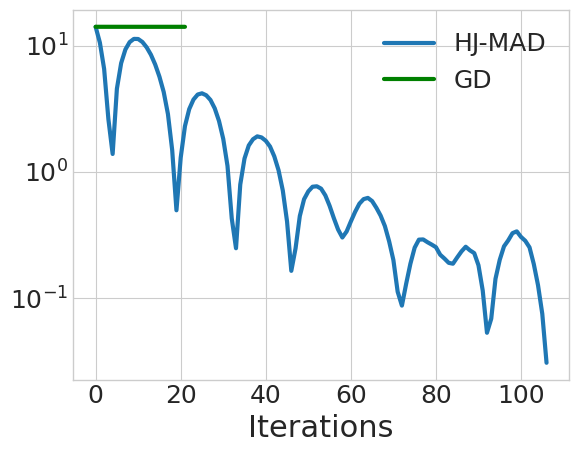

In [536]:
title_fontsize = 22
fontsize       = 18
fig1 = plt.figure()

plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.semilogy(xk_error_hist_MAD, color=my_blue, linewidth=3);
# ax.semilogy(xk_error_hist_EGD[0:len(xk_error_hist_GD)], 'm-', linewidth=3)
ax.semilogy(xk_error_hist_GD[0:len(xk_error_hist_GD)], 'g-', linewidth=3)

ax.set_xlabel("Iterations", fontsize=title_fontsize)
ax.legend(['HJ-MAD', 'GD'],fontsize=fontsize)
# title_str = 'Relative Errors'
# ax.set_title(title_str, fontsize=title_fontsize)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'griewank_error_hist.png'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

/tmp/ipykernel_53487/2354976602.py:16: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)


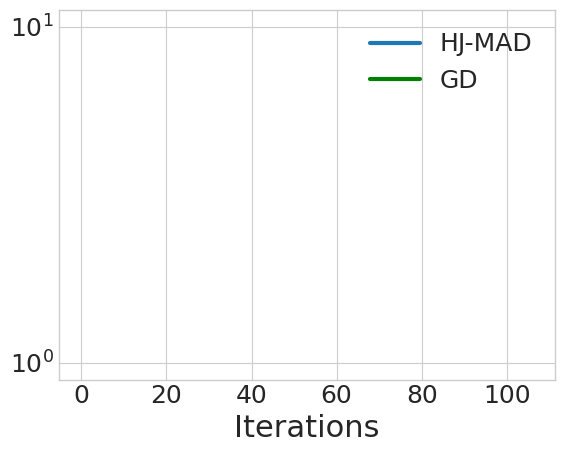

In [537]:
fig1 = plt.figure()

plt.style.use('seaborn-whitegrid')
ax = plt.axes()
ax.semilogy(fk_hist_MAD, color=my_blue, linewidth=3);
# ax.semilogy(fk_hist_EGD[0:len(xk_error_hist_GD)], 'm-', linewidth=3)
ax.semilogy(fk_hist_GD[0:len(xk_error_hist_GD)], 'g-', linewidth=3)

ax.set_xlabel("Iterations", fontsize=title_fontsize)
ax.legend(['HJ-MAD', 'GD'],fontsize=fontsize)
# title_str = 'Objective Function Values'
# ax.set_title(title_str, fontsize=title_fontsize)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

save_str = 'griewank_func_hist.png'
fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

/home/dnz75396/miniconda3/envs/myenv38/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


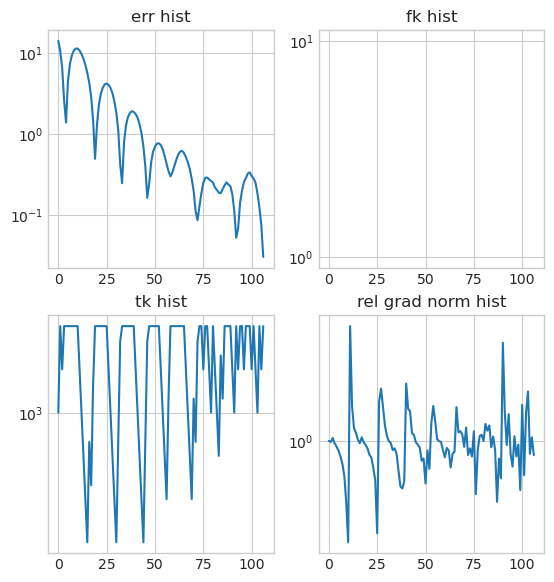

In [538]:
plt.figure()
plt.subplot(2,2,1)
plt.semilogy(xk_error_hist_MAD); plt.title('err hist')
plt.subplot(2,2,2)
plt.semilogy(fk_hist_MAD); plt.title('fk hist')
plt.subplot(2,2,3)
plt.semilogy(tk_hist_MAD); plt.title('tk hist')
plt.subplot(2,2,4)
plt.semilogy(rel_grad_uk_norm_hist_MAD); plt.title('rel grad norm hist')
plt.subplots_adjust(left=None, bottom=None, right=None, top=1.2, wspace=None, hspace=None)

### Save values

In [539]:
filename = 'rel_errs_MAD.dat'
with open(filename, 'w') as csv_file:
  for idx, f_val in enumerate(xk_error_hist_MAD):
    csv_file.write('%0.5e %0.5e\n' % (idx, f_val))

In [540]:
filename = 'rel_errs_GD.dat'
with open(filename, 'w') as csv_file:
  for idx, f_val in enumerate(xk_error_hist_GD):
    csv_file.write('%0.5e %0.5e\n' % (idx, f_val))

In [541]:
filename = 'f_hist_MAD.dat'
with open(filename, 'w') as csv_file:
  for idx, f_val in enumerate(fk_hist_MAD):
    csv_file.write('%0.5e %0.5e\n' % (idx, f_val))

In [542]:
filename = 'f_hist_GD.dat'
with open(filename, 'w') as csv_file:
  for idx, f_val in enumerate(fk_hist_GD):
    csv_file.write('%0.5e %0.5e\n' % (idx, f_val))

In [543]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import torch

from scipy import optimize

## Benchmark Functions

We also try some of scipy's global optimization algorithms on our test functions

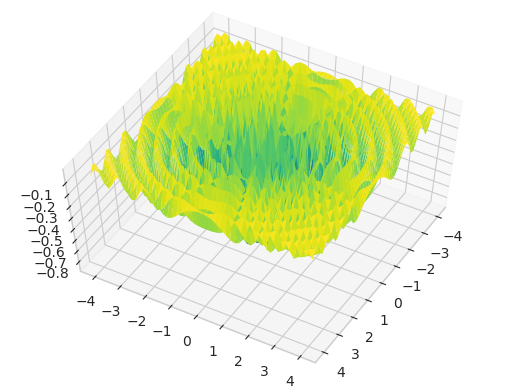

In [544]:
from mpl_toolkits.mplot3d import Axes3D

ax_bry_3D_plot = 4
surface_plot_resolution = 50
x = np.linspace(-ax_bry_3D_plot, ax_bry_3D_plot, surface_plot_resolution)
y = np.linspace(-ax_bry_3D_plot, ax_bry_3D_plot, surface_plot_resolution)

X, Y = np.meshgrid(x, y)

Z     = np.zeros(X.shape)
for i in range(X.shape[0]):
  for j in range(X.shape[1]):
    # convert to torch tensor and reshape to n_samples x n_features
    current_coordinate = torch.FloatTensor([X[i,j],Y[i,j]]).view(1, -1)
    Z[i,j] = f(current_coordinate)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis',
                 edgecolor='none')
ax.view_init(60, 30) 

## Run Optimization Algorithms

In [545]:
max_iter = int(5e4)
basin_hopping_local_niter = int_samples # 100 iterations at each local minimization
bounds = [(-20, 20), (-20, 20)]
res_basin_hopping   = optimize.basinhopping(f_numpy, np.asarray(x0), niter=basin_hopping_local_niter)
res_DE              = optimize.differential_evolution(f_numpy, bounds, maxiter=max_iter)
res_dual_annealing  = optimize.dual_annealing(f_numpy, bounds, maxiter=max_iter)

In [546]:
res_DE

 message: Optimization terminated successfully.
 success: True
     fun: -0.9362453278079412
       x: [-4.827e-01  1.939e-01]
     nit: 24
    nfev: 762
     jac: [ 6.661e-08  1.554e-07]

In [547]:
res_basin_hopping

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -0.999999999999997
                          x: [-3.695e-09 -8.298e-09]
                        nit: 1000
      minimization_failures: 0
                       nfev: 21153
                       njev: 7051
 lowest_optimization_result:  message: Optimization terminated successfully.
                              success: True
                               status: 0
                                  fun: -0.999999999999997
                                    x: [-3.695e-09 -8.298e-09]
                                  nit: 5
                                  jac: [ 2.682e-07 -6.706e-08]
                             hess_inv: [[ 9.320e-01 -2.605e-01]
                                        [-2.605e-01  8.770e-02]]
                                 nfev: 81
                                 njev: 27

In [548]:
res_dual_annealing

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: -1.0
       x: [-5.929e-10  9.801e-10]
     nit: 50000
    nfev: 533377
    njev: 111112
    nhev: 0

In [549]:
print('\n\n avg_func_evals = ', avg_func_evals)
print(f"Average iterations before convergence: {average_iterations:.2f}")
print(f"Average elapsed time: {sum_elapsed_time / avg_trials:.4f} seconds")



 avg_func_evals =  89070.0
Average iterations before convergence: 89.07
Average elapsed time: 0.0283 seconds
